# Credit scoring problem
**Project Description:** 

**Goal:** 

**Objectives:** 

**Dataset Description:** Dataset consists of 73 799 rows into train set and 36 349 rows into test set.

Dataset features:
1. client_id - идентификатор клиента
2. education - уровень образования
3. sex - пол заёмщика
4. age - возраст заёмщика
5. car - флаг наличия автомобиля
6. car_type - флаг автомобиля-иномарки
7. decline_app_cnt - количество отказанных прошлых заявок
8. good_work - флаг наличия «хорошей» работы
9. bki_request_cnt - количество запросов в БКИ
10. home_address - категоризатор домашнего адреса
11. work_address - категоризатор рабочего адреса
12. income - доход заёмщика
13. foreign_passport - наличие загранпаспорта
14. sna - связь заемщика с клиентами банка
15. first_time - давность наличия информации о заемщике
16. score_bki - скоринговый балл по данным из БКИ
17. region_rating - рейтинг региона
18. app_date - дата подачи заявки
19. default - наличие дефолта

# План
1. Провести базовую (default) обработку новых признаков и добавить их в baseline.
2. При помощи двух baseline submition (с признаком 'client_id' и без него) выяснить полезность признака 'client_id'. В тестовой выборке данные признака 'client_id' могут быть заменены на простую последовательность.
3. Поочередно провести полную оптимизацию всех изначальных признаков (без feature engineering) с настройками обучения модели по умолчанию (по baseline).
4. Feature engineering + polynomial features + dummies.
5. Find optimum sample value to define usefull features.
6. Find usefull features.
7. Optimize hyperparameters.
8. Try oversampling and undersampling.
9. Try to overfit to public liderboard (for this competition only).

In [56]:
import os
import re
import math
import statistics
from collections import Counter, defaultdict
from itertools import chain, combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import ttest_ind
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, confusion_matrix, auc, roc_auc_score, roc_curve, SCORERS
from sklearn.utils.class_weight import compute_class_weight

pd.options.display.max_columns = 40

In [57]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/lib/kaggle/gcp.py
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/kernel341ca18171/requirements.txt
/kaggle/input/kernel341ca18171/train_test_score_vs_feature_number.csv
/kaggle/input/kernel341ca18171/__results__.html
/kaggle/input/kernel341ca18171/__output__.json
/kaggle/input/kernel341ca18171/custom.css
/kaggle/input/kernel341ca18171/__notebook_source__.ipynb
/kaggle/input/kernel341ca18171/__notebook__.ipynb
/kaggle/input/kernel341ca18171/train_test_score_vs_sample_value.csv
/kaggle/input/kernel341ca18171/__results___files/__results___64_0.png
/kaggle/input/kernel341ca18171/__results___files/__results___42_0.png
/kaggle/input/kernel341ca18171/__results___files/__results___52_0.png
/kaggle/input/kernel341ca18171/__results___files/__results___79_2.png
/kaggle/input/kernel341ca18171/__results___files/__results___46_0.png
/kaggle/input/kernel341ca18171/__results___files/__results___77_1.

In [58]:
# Save requirements
!pip freeze > requirements.txt

In [59]:
# G L O B A L   C O N S T A N T S
# Random seed
RANDOM_SEED = 42
# Suffix for features with power of -1
MINUS_ONE_SUFFIX = '_1'
# Suffix for duplicated features in various feature category
DUPLICATE_SUFFIX = '_dup'
# Target feature
TARGET = 'default'
# ID feature
IDENT = 'client_id'
# Feature to separate train and test data
TRAIN = 'TRAIN'
# Data, kernel and working paths
PATH_DATA = '/kaggle/input/sf-dst-scoring/'
PATH_KERNEL = '/kaggle/input/kernel341ca18171/'
PATH_WORKING = '/kaggle/working/'

# Data preparing
## Collecting and formating

In [60]:
def collect_data():
    """Read train and test datasets and join them"""
    # Datasets reading
    df_train = pd.read_csv(PATH_DATA+'train.csv')
    df_test = pd.read_csv(PATH_DATA+'test.csv')
    sample_submission = pd.read_csv(PATH_DATA+'sample_submission.csv')

    # Join train and test datasets
    df_train[TRAIN] = 1 # Train flag = 1
    df_test[TRAIN] = 0 # Train flag = 0
    df_test[TARGET] = 0 # Fill target variable of the test dataset with zeros
    df_join = df_train.append(df_test, ignore_index=True) # Join
    
    # Oversampling for minor target class
#     zzz = df_join.loc[(df_join[TRAIN]==1)&(df_join[TARGET]==1)].copy()
#     df_join = df_join.append(zzz, ignore_index=True) # Join
#     df_join = df_join.append(zzz, ignore_index=True) # Join

    return (df_join, sample_submission)


def check_features_format(df):
    """Check format of dataframe features"""
    # Features to check
    cols_regex = {
        'app_date': '\d{2}[A-Z]{3}\d{4}',
    }

    # Check and print result
    for column, regex in cols_regex.items():
        a = df[column].str.match(regex).sum()
        b = df[column].count()
        print(f"'{column}' feature matches the regex format '{regex}' for {a} of {b} rows")


def format_edu(value):
    """Convert 'education' feature values to numbers"""
    if value == '':
        return np.nan
    return {'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5}[value]


def format_features(df):
    """Format dataset"""
    df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')
    df['app_date'] =  (df['app_date'] - df['app_date'].min()).dt.days
    df['region_rating'] =  (df['region_rating'] // 10) - 1

## Feature engineering

In [61]:
def create_new_features(df):
    # Create binary features for NaN's
    df['education_NaN'] = df['education'].isna().astype('uint8')
    
    # Create duplicate of categorical columns for either ordinal and/or quantity features
    df['education'+DUPLICATE_SUFFIX] = df['education'].apply(lambda x: format_edu(x) if x is not np.nan else np.nan)
    df['first_time'+DUPLICATE_SUFFIX] = df['first_time']
    df['home_address'+DUPLICATE_SUFFIX] = df['home_address']
    df['region_rating'+DUPLICATE_SUFFIX] = df['region_rating']
    df['region_rating'+DUPLICATE_SUFFIX+DUPLICATE_SUFFIX] = df['region_rating']
    df['sna'+DUPLICATE_SUFFIX] = df['sna']
    df['work_address'+DUPLICATE_SUFFIX] = df['work_address']

    # Create -1 degree quantity features
    df['age'+MINUS_ONE_SUFFIX] = 1 / (df['age'] - df['age'].min() + abs(df['age'].mean()) + 1)
    df['client_id'+MINUS_ONE_SUFFIX] = 1 / (df['client_id'] - df['client_id'].min() + abs(df['client_id'].mean()) + 1)
    df['income'+MINUS_ONE_SUFFIX] = 1 / (df['income'] - df['income'].min() + abs(df['income'].mean()) + 1)
#     df['score_bki'+MINUS_ONE_SUFFIX] = 1 / (df['score_bki'] - df['score_bki'].min() + abs(df['score_bki'].mean()) + 1)
    df['score_bki'+MINUS_ONE_SUFFIX] = 1 / (df['score_bki'].max() - df['score_bki'] + abs(df['score_bki'].mean()) + 1)
    df['decline_app_cnt'+MINUS_ONE_SUFFIX] = 1 / (df['decline_app_cnt'] - df['decline_app_cnt'].min() + abs(df['decline_app_cnt'].mean()) + 1)
    df['bki_request_cnt'+MINUS_ONE_SUFFIX] = 1 / (df['bki_request_cnt'] - df['bki_request_cnt'].min() + abs(df['bki_request_cnt'].mean()) + 1)
    df['app_date'+MINUS_ONE_SUFFIX] = 1 / (df['app_date'] - df['app_date'].min() + abs(df['app_date'].mean()) + 1)
    df['region_rating'+DUPLICATE_SUFFIX+DUPLICATE_SUFFIX+MINUS_ONE_SUFFIX] = 1 / (df['region_rating'] - df['region_rating'].min() + abs(df['region_rating'].mean()) + 1)
    
    # Create categorical and ordinal feature of decline_app_cnt
    df['decline_app_cnt'+DUPLICATE_SUFFIX] = df['decline_app_cnt']
    df.loc[df['decline_app_cnt'+DUPLICATE_SUFFIX] > 2, 'decline_app_cnt'+DUPLICATE_SUFFIX] = 2
    df['decline_app_cnt'+DUPLICATE_SUFFIX+DUPLICATE_SUFFIX] = df['decline_app_cnt'+DUPLICATE_SUFFIX]

## Deleting of useless features

In [62]:
def delete_useless_features(df):
    """Delete useless features"""
    pass

## Dirty data (wrong values) handling

In [63]:
def dirty_handling(df):
    """Replace wrong values to NaN for features with finit set of posible values"""
    pass

## Receiving of general information

In [64]:
df_join, sample_submission = collect_data()
check_features_format(df_join)
format_features(df_join)
create_new_features(df_join)
delete_useless_features(df_join)
dirty_handling(df_join)

'app_date' feature matches the regex format '\d{2}[A-Z]{3}\d{4}' for 110148 of 110148 rows


**Show general information of datasets**

In [65]:
df_join.loc[df_join[TRAIN] == 1].head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,TRAIN,education_NaN,education_dup,first_time_dup,home_address_dup,region_rating_dup,region_rating_dup_dup,sna_dup,work_address_dup,age_1,client_id_1,income_1,score_bki_1,decline_app_cnt_1,bki_request_cnt_1,app_date_1,region_rating_dup_dup_1,decline_app_cnt_dup,decline_app_cnt_dup_dup
0,25905,31,SCH,M,62,Y,Y,0,0,-2.008753,1,4,1,2,18000,4,1,N,0,1,0,1.0,1,1,4,4,4,2,0.012308,0.000012,0.000017,0.195578,0.785419,0.249688,0.010756,0.115272,0,0
1,63161,70,SCH,F,59,N,N,0,0,-1.532276,3,4,2,3,19000,4,1,N,0,1,0,1.0,1,2,4,4,4,3,0.012780,0.000008,0.000017,0.215676,0.785419,0.166528,0.007577,0.115272,0,0
2,25887,31,SCH,M,25,Y,N,2,0,-1.408142,1,7,1,2,30000,1,4,Y,0,1,0,1.0,4,1,7,7,1,2,0.022599,0.000012,0.000014,0.221609,0.305511,0.249688,0.010756,0.085652,2,2
3,16222,22,SCH,F,53,N,N,0,0,-2.057471,2,4,2,3,10000,1,3,N,0,1,0,1.0,3,2,4,4,1,3,0.013841,0.000014,0.000020,0.193732,0.785419,0.199800,0.011909,0.115272,0,0
4,101655,107,GRD,M,48,N,N,0,1,-1.244723,1,5,2,3,30000,1,4,Y,0,1,0,3.0,4,2,5,5,1,3,0.014870,0.000006,0.000014,0.229936,0.785419,0.249688,0.005918,0.103358,0,0


In [66]:
df_join.loc[df_join[TRAIN] == 0].head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,TRAIN,education_NaN,education_dup,first_time_dup,home_address_dup,region_rating_dup,region_rating_dup_dup,sna_dup,work_address_dup,age_1,client_id_1,income_1,score_bki_1,decline_app_cnt_1,bki_request_cnt_1,app_date_1,region_rating_dup_dup_1,decline_app_cnt_dup,decline_app_cnt_dup_dup
73799,74835,80,GRD,M,29,Y,Y,0,0,-2.271884,3,4,1,2,50000,1,4,N,0,0,0,3.0,4,1,4,4,1,2,0.020726,0.000008,0.000011,0.186005,0.785419,0.166528,0.007044,0.115272,0,0
73800,17527,23,SCH,F,39,N,N,5,0,-1.504999,2,4,1,2,5000,4,3,N,0,0,0,1.0,3,1,4,4,4,2,0.017168,0.000014,0.000022,0.216952,0.159408,0.199800,0.011769,0.115272,2,2
73801,75683,81,UGR,M,50,Y,Y,0,0,-1.691339,1,4,1,2,30000,1,3,Y,0,0,0,2.0,3,1,4,4,1,2,0.014441,0.000008,0.000014,0.208522,0.785419,0.249688,0.006994,0.115272,0,0
73802,26883,33,SCH,M,56,N,N,0,0,-2.374182,1,3,1,2,17000,1,3,N,0,0,0,1.0,3,1,3,3,1,2,0.013289,0.000012,0.000018,0.182532,0.785419,0.249688,0.010529,0.130291,0,0
73803,28862,34,GRD,F,38,N,N,0,0,-2.487502,0,7,2,3,120000,1,3,N,0,0,0,3.0,3,2,7,7,1,3,0.017467,0.000012,0.000006,0.178833,0.785419,0.332778,0.010420,0.085652,0,0


In [67]:
df_join.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,TRAIN,education_NaN,education_dup,first_time_dup,home_address_dup,region_rating_dup,region_rating_dup_dup,sna_dup,work_address_dup,age_1,client_id_1,income_1,score_bki_1,decline_app_cnt_1,bki_request_cnt_1,app_date_1,region_rating_dup_dup_1,decline_app_cnt_dup,decline_app_cnt_dup_dup
0,25905,31,SCH,M,62,Y,Y,0,0,-2.008753,1,4,1,2,18000,4,1,N,0,1,0,1.0,1,1,4,4,4,2,0.012308,0.000012,0.000017,0.195578,0.785419,0.249688,0.010756,0.115272,0,0
1,63161,70,SCH,F,59,N,N,0,0,-1.532276,3,4,2,3,19000,4,1,N,0,1,0,1.0,1,2,4,4,4,3,0.012780,0.000008,0.000017,0.215676,0.785419,0.166528,0.007577,0.115272,0,0
2,25887,31,SCH,M,25,Y,N,2,0,-1.408142,1,7,1,2,30000,1,4,Y,0,1,0,1.0,4,1,7,7,1,2,0.022599,0.000012,0.000014,0.221609,0.305511,0.249688,0.010756,0.085652,2,2
3,16222,22,SCH,F,53,N,N,0,0,-2.057471,2,4,2,3,10000,1,3,N,0,1,0,1.0,3,2,4,4,1,3,0.013841,0.000014,0.000020,0.193732,0.785419,0.199800,0.011909,0.115272,0,0
4,101655,107,GRD,M,48,N,N,0,1,-1.244723,1,5,2,3,30000,1,4,Y,0,1,0,3.0,4,2,5,5,1,3,0.014870,0.000006,0.000014,0.229936,0.785419,0.249688,0.005918,0.103358,0,0


In [68]:
sample_submission.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [69]:
df_join.loc[df_join[TRAIN] == 1].info()
print()
df_join.loc[df_join[TRAIN] == 0].info()
print()
df_join.info()
print()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                73799 non-null  int64  
 1   app_date                 73799 non-null  int64  
 2   education                73492 non-null  object 
 3   sex                      73799 non-null  object 
 4   age                      73799 non-null  int64  
 5   car                      73799 non-null  object 
 6   car_type                 73799 non-null  object 
 7   decline_app_cnt          73799 non-null  int64  
 8   good_work                73799 non-null  int64  
 9   score_bki                73799 non-null  float64
 10  bki_request_cnt          73799 non-null  int64  
 11  region_rating            73799 non-null  int64  
 12  home_address             73799 non-null  int64  
 13  work_address             73799 non-null  int64  
 14  income                

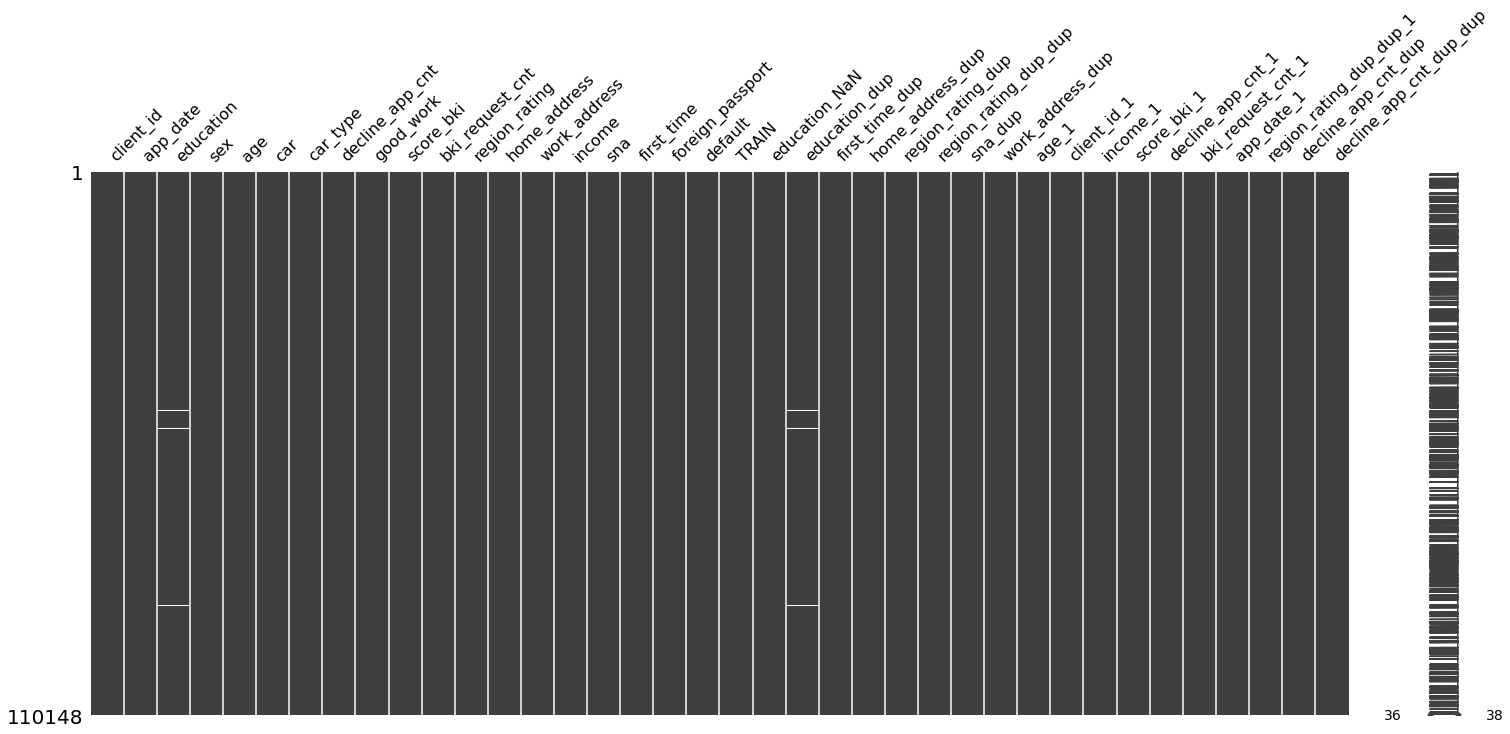

In [70]:
msno.matrix(df_join);

**Declare target variable, quantity, ordinal and categorical features**

In [16]:
# Declare categorical features
categ_bin_cols = [
    'car',
    'car_type',
    'foreign_passport',
    'good_work',
    'sex',
    
    'education_NaN',
]
categ_many_cols = [
    'education',
    'decline_app_cnt'+DUPLICATE_SUFFIX+DUPLICATE_SUFFIX,
    'first_time',
    'home_address',
    'region_rating',
    'sna',
    'work_address',
]
categ_multi_cols = [
]

# Declare quantity features
quantity_cols = [
    'age',
    'app_date',
    'bki_request_cnt',
    'client_id',
    'decline_app_cnt',
    'income',
    'score_bki',
    
    'region_rating'+DUPLICATE_SUFFIX+DUPLICATE_SUFFIX,
    'region_rating'+DUPLICATE_SUFFIX+DUPLICATE_SUFFIX+MINUS_ONE_SUFFIX,
    'age'+MINUS_ONE_SUFFIX,
    'app_date'+MINUS_ONE_SUFFIX,
    'bki_request_cnt'+MINUS_ONE_SUFFIX,
    'client_id'+MINUS_ONE_SUFFIX,
    'decline_app_cnt'+MINUS_ONE_SUFFIX,
    'income'+MINUS_ONE_SUFFIX,
    'score_bki'+MINUS_ONE_SUFFIX,
]

# Declare categorized quantity features
quantity_categ_cols = [
]

# Declare ordinal features
ordinal_cols = [
    'decline_app_cnt'+DUPLICATE_SUFFIX,
    'education'+DUPLICATE_SUFFIX,
    'first_time'+DUPLICATE_SUFFIX,
    'home_address'+DUPLICATE_SUFFIX,
    'region_rating'+DUPLICATE_SUFFIX,
    'sna'+DUPLICATE_SUFFIX,
    'work_address'+DUPLICATE_SUFFIX,
]

# Update quantity, ordinal and categorical feature lists
categ_bin_cols = [col for col in categ_bin_cols if col in df_join.columns]
categ_many_cols = [col for col in categ_many_cols if col in df_join.columns]
categ_multi_cols = [col for col in categ_multi_cols if col in df_join.columns]
categ_cols = categ_bin_cols + categ_many_cols + categ_multi_cols
quantity_cols = [col for col in quantity_cols if col in df_join.columns]
quantity_categ_cols = [col for col in quantity_categ_cols if col in df_join.columns]
ordinal_cols = [col for col in ordinal_cols if col in df_join.columns]

**View unique values**

In [ ]:
# Find and show number of unique values of categorical features
categorical_unique = {}
for column in categ_cols:
    # Handle categ_multi_cols features
    if column in categ_multi_cols:
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df_join.loc[df_join[column].notna(), column].str.split('|')))).sort_values(ascending=False)

    # Handle categ_bin_cols and categ_many_cols features
    else:
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df_join.loc[df_join[column].notna(), column].apply(lambda x: [x])))).sort_values(ascending=False)

    # Show result
    print((column + ':').ljust(21), end='')
    print(str(len(categorical_unique[column])).rjust(6))

car:                      2
car_type:                 2
foreign_passport:         2
good_work:                2
education_NaN:            2
education:                5
decline_app_cnt_dup_dup:     3
first_time:               4
home_address:             3
region_rating:            7


In [ ]:
# Show unique values of categorical features
pd.set_option('display.max_rows', None)

for column in categ_cols:
    print(column + ':')
    print(categorical_unique[column]) # in frequency order
#     print(categorical_unique[column].sort_index()) # in alphabet order
    print()
    
pd.reset_option('display.max_rows')

In [ ]:
# Show distribution of categorical features
for column in categ_cols:
    categorical_unique[column].plot.bar(figsize=(18, 6), title=column)
    plt.show()

In [20]:
# Show number of unique values of quantity and ordinal features
for column in quantity_cols + quantity_categ_cols + ordinal_cols:
    print(column.join(['', ':']).ljust(21), end='')
    print(str(df_join[column].nunique()).rjust(6))

age:                     52
app_date:               120
bki_request_cnt:         40
client_id:           110148
decline_app_cnt:         24
income:                1207
score_bki:           102618
region_rating_dup_dup:     7
region_rating_dup_dup_1:     7
age_1:                   52
app_date_1:             120
bki_request_cnt_1:       40
client_id_1:         110148
decline_app_cnt_1:       24
income_1:              1207
score_bki_1:         102618
decline_app_cnt_dup:      3
education_dup:            5
first_time_dup:           4
home_address_dup:         3
region_rating_dup:        7
sna_dup:                  4
work_address_dup:         3


In [21]:
# Show unique values of quantity and ordinal features
columns = ['decline_app_cnt',
           'bki_request_cnt',]

for column in quantity_cols + quantity_categ_cols + ordinal_cols:
    if column in columns:
        print(column.join(['', ':']).ljust(21), end='')
        print(np.sort(df_join[column].unique()))

bki_request_cnt:     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 33 34 36 40 41 45 46 47 53]
decline_app_cnt:     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 19 20 21 22 24 30 33]


## Visualization

In [22]:
def show_boxplots(df, show_target=False):
    """Show boxplots of quantity and ordinal features and check them for outliers existance"""
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 5
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*5))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].boxplot(df.loc[df[column].notna(), column], showmeans=True)
        axs[idx].set_title(column)
        
        
def show_histograms(df, show_target=False):
    """Show distributions of quantity and ordinal features"""
    # Fill the list of bins' step if know it
    bin_step = {
        'age': 1,
        'default': 1,
        'decline_app_cnt': 1,
        'bki_request_cnt': 1,
        'education': 1,
    }
    
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil(len(columns)/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        # Calculate indices of subplots
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)

        # Calculate number of bins and ranges
        if column in bin_step.keys():
            col_max = df[column].max()
            col_min = df[column].min()
            step = bin_step[column]
            offset = step / 2
            bins = int((col_max-col_min) / step) + 1
            range_ = (col_min - offset, col_max + offset)
        elif column in ordinal_cols:
            col_max = df[column].max()
            col_min = df[column].min()
            bins = int((col_max-col_min) * 2) + 1
            range_ = (col_min - 0.25, col_max + 0.25)
        else:
            bins = 20
            range_ = None

        # Plot
        axs[idx].hist(df.loc[df[column].notna(), column], bins, range_)
        axs[idx].set_title(column)
        
        
def show_CQF_boxplots(df):
    """Show boxplots of categorized quantity features"""
    NUM_OF_VALS = 10
    CATEGORY = 'feature_name'

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    categ_mask = {}
    top_categ_values = {}
    for i, column in enumerate(quantity_categ_cols):
        # Find masks
        categ_mask = {}
        top_categ_values = {}
        for column in quantity_categ_cols:
            # Find top NUM_OF_VALS values categorical feature
            top_categ_values[column] = categorical_unique[CATEGORY].index[:NUM_OF_VALS]

            # Find boolean masks
            categ_mask[column] = {}
            for value in top_categ_values[column]:
                categ_mask[column][value] = df[CATEGORY].str.contains(value)

        # Plot graphs
        if rows == 1:
            axs.boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_categ_values[column], rotation=5)
        else:
            axs[i].boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_categ_values[column], rotation=5)
            
    return (top_categ_values, categ_mask)
            
            
def show_CQF_histograms(df, top_categ_values, categ_mask):
    """Show distributions of categorized quantity features"""
    BINS = 100

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    for i, column in enumerate(quantity_categ_cols):
        # Plot graphs
        if rows == 1:
            for value in top_categ_values[column]:
                axs.hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs.set_title(column)
        else:
            for value in top_categ_values[column]:
                axs[i].hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs[i].set_title(column)

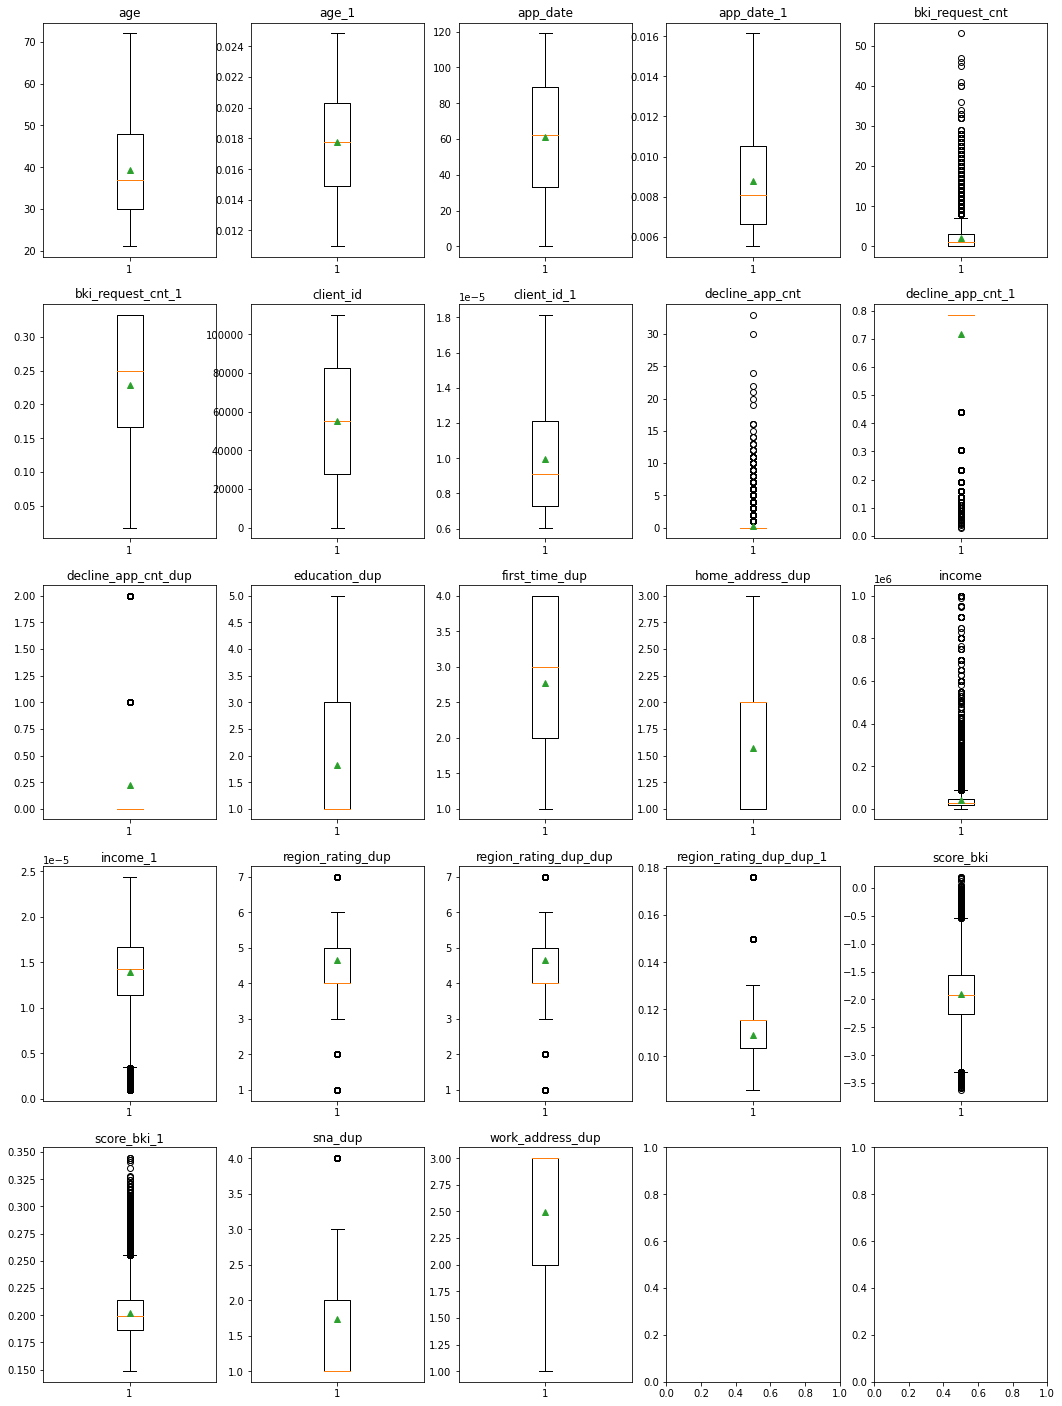

In [23]:
show_boxplots(df_join)

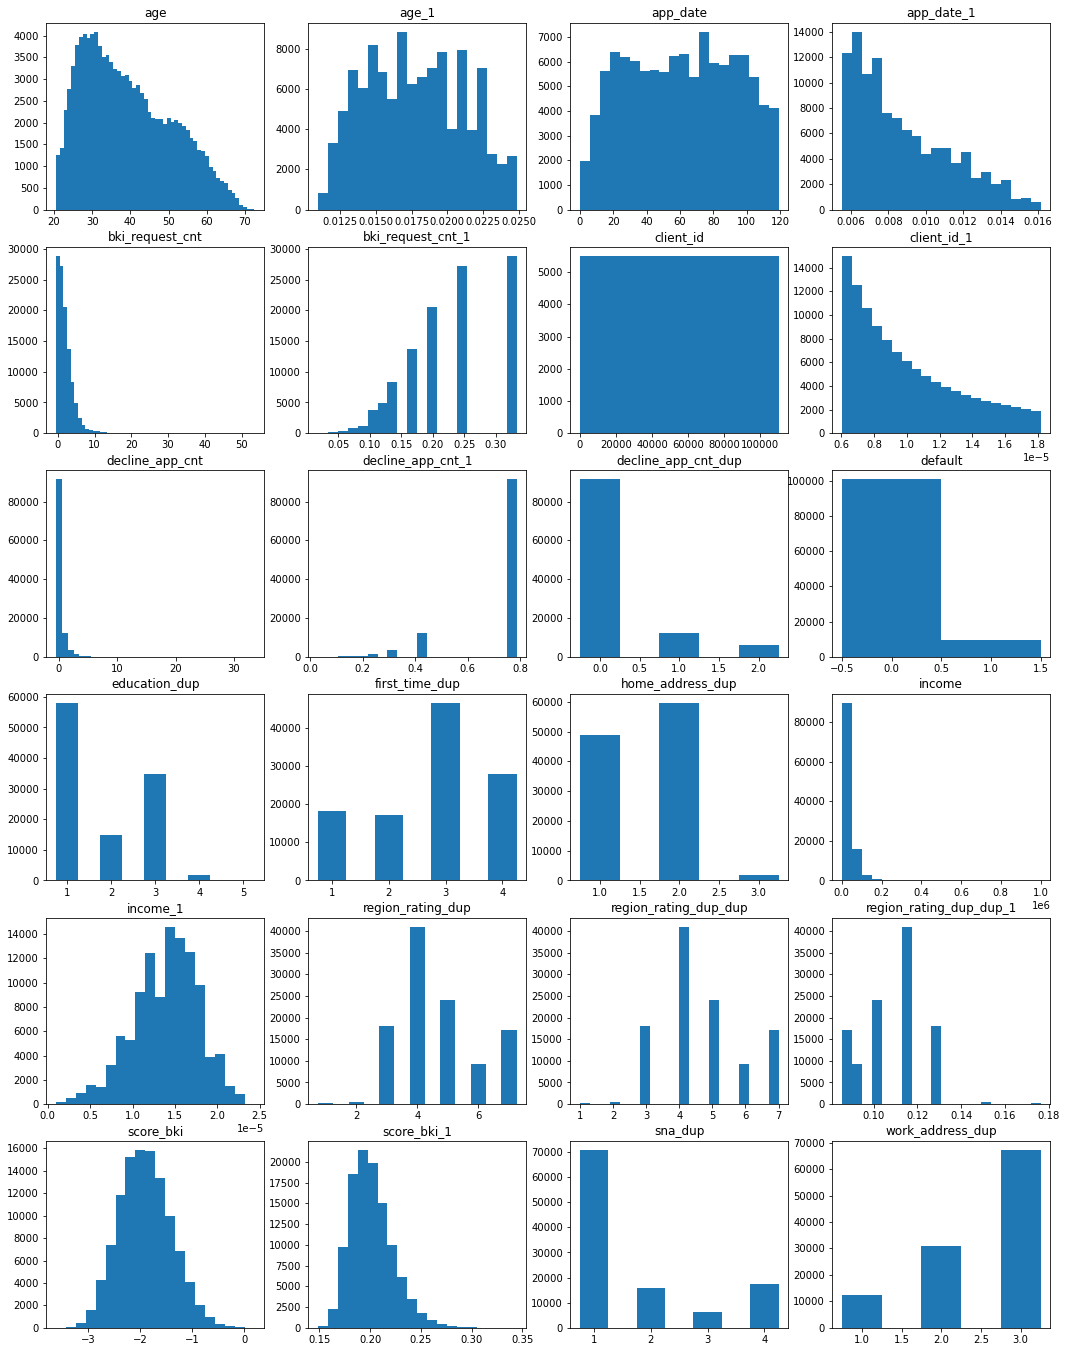

In [24]:
show_histograms(df_join, show_target=True)

In [25]:
# top_categ_values, categ_mask = show_CQF_boxplots(df_join)

In [26]:
# show_CQF_histograms(df_join, top_categ_values, categ_mask)

## Outliers handling

In [27]:
def delete_outliers(df, inplace=False):
    """Show number of outliers and delete rows with outliers"""
    # Define columns to show graphs
    columns = sorted(quantity_cols).copy()
    # Exclude some columns from the process
    cols = [
        'region_rating_dup_dup',
        'age_1',
        'app_date_1',
        'bki_request_cnt',
        'client_id_1',
        'decline_app_cnt',
        'decline_app_cnt_1',
        'income',
        'income_1',
        'region_rating_dup_dup_1',
        'score_bki',
        'score_bki_1',
    ]
    for col in df_join.columns:
        if col in cols:
            columns.remove(col)
    
    idx_dict = {}
    for column in columns:
        # Calculate Q1, Q3, IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate indices of rows
        idx_dict[column] = list(df.loc[(~df[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)) & (df[column].notna()), column].index)

        # Show the result
        outliers_num = len(idx_dict[column])
        if outliers_num:
            print(f"{str(outliers_num).rjust(6)} outliers are in column '{column}'")
            
    # Union indices
    idx = set()
    for column in columns:
        idx.update(idx_dict[column])

    # Drop rows with outliers
    if inplace:
        df.drop(idx, inplace=True)
        print(f"{str(len(idx)).rjust(6)} rows have been dropped")

In [28]:
# Show or delete outliers
print('train:')
delete_outliers(df_join.loc[df_join[TRAIN] == 1])
print('test:')
delete_outliers(df_join.loc[df_join[TRAIN] == 0])
print('join:')
delete_outliers(df_join)

train:
test:
join:


## Correlation analysis

In [29]:
# Calculate correlation matrix
corr_table = df_join.loc[df_join[TRAIN] == 1].corr()
corr_table

,client_id,app_date,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,TRAIN,education_NaN,education_dup,first_time_dup,home_address_dup,region_rating_dup,region_rating_dup_dup,sna_dup,work_address_dup,age_1,client_id_1,income_1,score_bki_1,decline_app_cnt_1,bki_request_cnt_1,app_date_1,region_rating_dup_dup_1,decline_app_cnt_dup,decline_app_cnt_dup_dup
client_id,1.000000,0.999582,0.015435,-0.021417,0.004749,-0.063293,-0.029028,0.008233,0.165555,0.165777,-0.000099,-0.004195,0.017277,-0.039242,NaN,-0.011157,0.040353,0.017277,0.165555,0.008233,0.008233,-0.004195,0.165777,-0.017246,-0.961025,-0.001951,-0.063788,0.021831,0.006537,-0.964250,-0.008209,-0.022887,-0.022887
app_date,0.999582,1.000000,0.015676,-0.021352,0.004665,-0.063605,-0.029165,0.007125,0.164086,0.164073,-0.000454,-0.004118,0.016932,-0.039372,NaN,-0.011272,0.040227,0.016932,0.164086,0.007125,0.007125,-0.004118,0.164073,-0.017482,-0.962536,-0.001533,-0.064134,0.021737,0.006584,-0.966438,-0.007162,-0.022770,-0.022770
age,0.015435,0.015676,1.000000,-0.111175,-0.076158,-0.106275,0.046265,-0.089501,0.010392,-0.006299,-0.018900,-0.059542,0.079046,-0.025004,NaN,0.013776,-0.127841,0.079046,0.010392,-0.089501,-0.089501,-0.059542,-0.006299,-0.981577,-0.015887,0.116451,-0.101371,0.120531,-0.043311,-0.016278,0.088668,-0.119293,-0.119293
decline_app_cnt,-0.021417,-0.021352,-0.111175,1.000000,-0.027359,0.189987,0.155894,-0.038505,0.012530,0.016234,-0.021687,0.065297,-0.069099,0.113682,NaN,-0.013783,-0.030331,-0.069099,0.012530,-0.038505,-0.038505,0.065297,0.016234,0.119442,0.019183,0.010566,0.194028,-0.870573,-0.106051,0.019377,0.037774,0.867246,0.867246
good_work,0.004749,0.004665,-0.076158,-0.027359,1.000000,0.006269,0.005738,0.073041,-0.003624,-0.008535,0.022705,-0.054041,0.055821,-0.043361,NaN,-0.002055,0.179605,0.055821,-0.003624,0.073041,0.073041,-0.054041,-0.008535,0.071952,-0.005883,-0.053076,0.007454,0.033797,-0.005894,-0.005661,-0.064489,-0.032853,-0.032853
score_bki,-0.063293,-0.063605,-0.106275,0.189987,0.006269,1.000000,0.156257,0.008959,0.013847,0.012648,-0.012639,0.067623,-0.069122,0.175369,NaN,-0.005879,-0.016561,-0.069122,0.013847,0.008959,0.008959,0.067623,0.012648,0.110779,0.056824,-0.002553,0.989629,-0.210416,-0.134236,0.057322,-0.007569,0.208630,0.208630
bki_request_cnt,-0.029028,-0.029165,0.046265,0.155894,0.005738,0.156257,1.000000,0.009025,0.008183,0.005553,0.082983,0.005139,0.014859,0.078242,NaN,-0.006180,0.034959,0.014859,0.008183,0.009025,0.009025,0.005139,0.005553,-0.053298,0.031030,-0.102123,0.159609,-0.155855,-0.862781,0.031036,-0.009960,0.154101,0.154101
region_rating,0.008233,0.007125,-0.089501,-0.038505,0.073041,0.008959,0.009025,1.000000,0.233820,0.253541,0.205674,-0.078199,0.088777,-0.089035,NaN,0.017661,0.125382,0.088777,0.233820,1.000000,1.000000,-0.078199,0.253541,0.091062,0.001050,-0.324460,0.013637,0.041514,0.016855,0.001456,-0.986101,-0.041037,-0.041037
home_address,0.165555,0.164086,0.010392,0.012530,-0.003624,0.013847,0.008183,0.233820,1.000000,0.728139,0.038343,0.115196,-0.058476,0.084637,NaN,0.004915,0.001018,-0.058476,1.000000,0.233820,0.233820,0.115196,0.728139,0.003454,-0.127944,-0.051742,0.015653,-0.011022,-0.003216,-0.129834,-0.203666,0.010937,0.010937
work_address,0.165777,0.164073,-0.006299,0.016234,-0.008535,0.012648,0.005553,0.253541,0.728139,1.000000,0.049721,0.111114,-0.063202,0.081582,NaN,0.005384,-0.000281,-0.063202,0.728139,0.253541,0.253541,0.111114,1.000000,0.018445,-0.129039,-0.073568,0.014648,-0.018065,0.000489,-0.130850,-0.226996,0.018043,0.018043


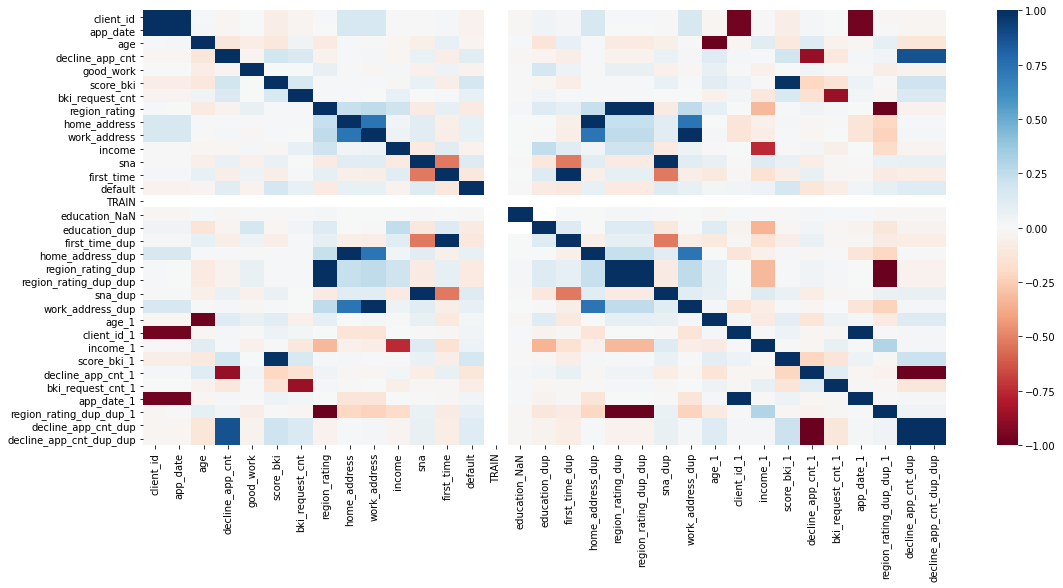

In [30]:
# Show correlation matrix
plt.subplots(figsize=(18, 8))
sns.heatmap(corr_table, vmin=-1, vmax=1, cmap="RdBu");

In [31]:
# Sort absolute correlation values with target variable
corr_table[TARGET].abs().sort_values(ascending=False)

default                    1.000000
score_bki_1                0.177676
score_bki                  0.175369
sna                        0.125832
sna_dup                    0.125832
decline_app_cnt_dup_dup    0.123135
decline_app_cnt_dup        0.123135
decline_app_cnt_1          0.123133
decline_app_cnt            0.113682
first_time_dup             0.105579
first_time                 0.105579
region_rating              0.089035
region_rating_dup_dup      0.089035
region_rating_dup          0.089035
region_rating_dup_dup_1    0.087990
education_dup              0.085033
home_address_dup           0.084637
home_address               0.084637
work_address_dup           0.081582
work_address               0.081582
bki_request_cnt            0.078242
bki_request_cnt_1          0.077002
income_1                   0.056967
good_work                  0.043361
income                     0.039752
app_date                   0.039372
client_id                  0.039242
app_date_1                 0

## Significance analysis of quantity and ordinal features
### Analysis of variance (ANOVA)

In [32]:
def anova_analysis(df):
    """Calculate and show significance of quantity and ordinal features based on ANOVA analysis"""
    columns = quantity_cols + ordinal_cols
    df_temp = df[columns + [TARGET]].dropna()
    pd.Series(f_classif(df_temp[columns], df_temp[TARGET])[0], index=columns).sort_values().plot(figsize=(18, 6), kind='barh');

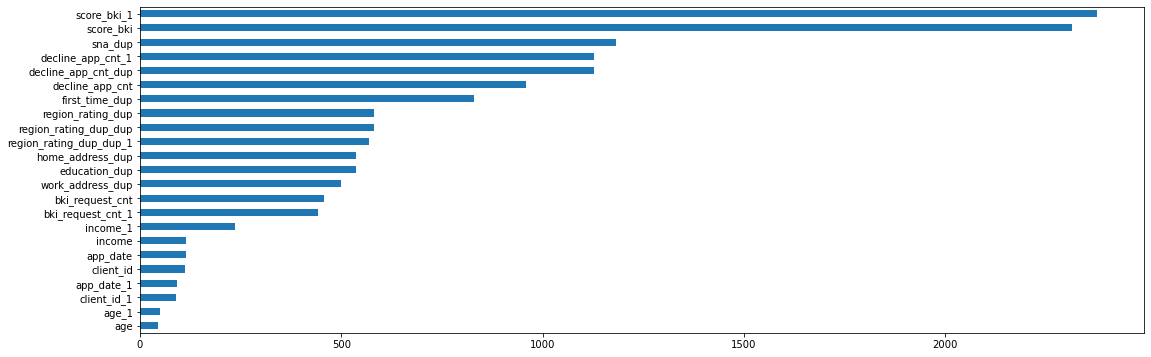

In [33]:
# Do ANOVA analysis
anova_analysis(df_join.loc[df_join[TRAIN] == 1])

## Significance analysis of categorical features
### Student's t-test

С помощью теста Стьюдента проверим есть ли статистически значимая разница в распределении целевой переменной для разных значений категориальных признаков. Проверяем нулевую гипотезу о том, что распределения целевой переменной по различным значениям категориальных переменных неразличимы.

In [34]:
def hypothesis_testing(df):
    """Hypothesis testing of significance analysis"""
    NUM_OF_VALS = 10

    # Find not significant features
    mask = {}
    top_values = {}
    not_signif_columns = []
    for column in categ_cols:
        # Find top NUM_OF_VALS values
        top_values[column] = categorical_unique[column].index[:NUM_OF_VALS]

        # Find boolean masks
        mask[column] = {}
        for value in top_values[column]:
            if column in categ_multi_cols:
                mask[column][value] = (df[column].str.contains('(?:^|\|)'+value+'(?:$|\|)')) & (df[TARGET].notna())
            else:
                mask[column][value] = (df[column] == value) & (df[TARGET].notna())

        # Student t-test for value combinations
        combs = list(combinations(top_values[column], 2))
        for comb in combs:
            if ttest_ind(df.loc[mask[column][comb[0]], TARGET], 
                         df.loc[mask[column][comb[1]], TARGET]) \
                            .pvalue <= 0.05/len(combs): # Bonferroni correction
                break
        else:
            not_signif_columns.append(column)

    # Show result
    if len(not_signif_columns):
        print('Statistically significant differences have NOT been found for features:')
        for column in not_signif_columns:
            print(f"'{column}'")
    else:
        print('All categorical features have statistically significant difference with target')
        
    return (top_values, mask)


def boxplot_significance(df, top_values, mask):
    """Show boxplots of features to view significance"""
    # Create figure with [rows x cols] graphs
    rows = len(categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(categ_cols):
        if rows == 1:
            axs.boxplot([df.loc[mask[column][value], TARGET] for value in top_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_values[column], rotation=5)
            axs.set_ylabel(TARGET)
        else:
            axs[i].boxplot([df.loc[mask[column][value], TARGET] for value in top_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_values[column], rotation=5)
            axs[i].set_ylabel(TARGET)

In [35]:
# Do hypothesis testing and show boxplots of significant features
top_values, mask = hypothesis_testing(df_join.loc[df_join[TRAIN] == 1])
boxplot_significance(df_join.loc[df_join[TRAIN] == 1], top_values, mask)

### Mutual information

In [36]:
def mutual_information_analysis(df):
    """Calculate and show significance of categorical features based on mutual information analysis"""
    columns = categ_bin_cols + categ_many_cols
    df_temp = df[columns + [TARGET]].dropna()
    pd.Series(mutual_info_classif(OrdinalEncoder().fit_transform(df_temp[columns]), df_temp[TARGET], discrete_features=True), index=columns).sort_values().plot(figsize=(18, 6), kind='barh');

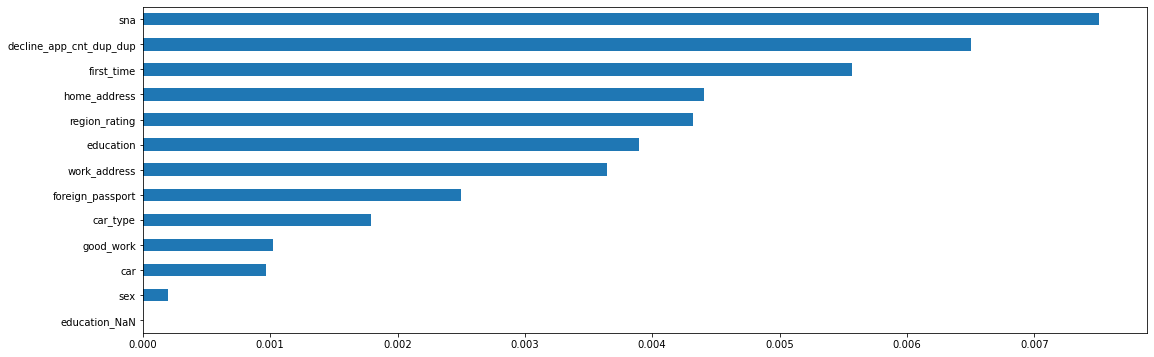

In [37]:
# Do mutual information analysis
mutual_information_analysis(df_join.loc[df_join[TRAIN] == 1])

**- Delete proportional and highly correlated features, and also features with week correlation with target variable**

**- Delete features without statistically significant difference**

In [38]:
# Define features to delete
cols = []

# Deleting
df_join.drop(columns=[col for col in cols if col in df_join.columns], inplace=True)

# Update feature list
categ_bin_cols = [col for col in categ_bin_cols if col in df_join.columns]
categ_many_cols = [col for col in categ_many_cols if col in df_join.columns]
categ_multi_cols = [col for col in categ_multi_cols if col in df_join.columns]
categ_cols = categ_bin_cols + categ_many_cols + categ_multi_cols
quantity_cols = [col for col in quantity_cols if col in df_join.columns]
quantity_categ_cols = [col for col in quantity_categ_cols if col in df_join.columns]
ordinal_cols = [col for col in ordinal_cols if col in df_join.columns]

## Missing values handling

In [39]:
# zzz = {}
# column = 'education'
# # dataz = df_join.loc[df_join[column].notna(), column]
# dataz = df_join.loc[(df_join[TARGET] == 0) & (df_join[column].notna()), column]
# zzz[column] = pd.Series(Counter(chain.from_iterable(dataz.apply(lambda x: [x])))).sort_values(ascending=False)

# # Show result
# print(zzz[column])

In [40]:
def fill_missing_values(df):
    # Drop rows with missing values of target variable
    nan_number = df[TARGET].isna().sum()
    if nan_number:
        df.dropna(subset=[TARGET], inplace=True)
        print(f"{nan_number} rows have been dropped in order to delete missed target values")

    # Drop rows with missing values
    pass
    
    # Fill missing values
    for column in quantity_cols + ordinal_cols + categ_cols:
        # Calculate number of replaced values
        nan_number = df[column].isna().sum()
        
        if nan_number:
            # For individual columns
            if column == 'column_name':
                value = 2
                
            elif column == 'column_2':
                values = df.groupby('categ_column')['column_2'].mean().round()
                df['zzz'] = df['categ_column'].map(values)
                idx = df['column_2'].isna()
                df.loc[idx, 'column_2'] = df.loc[idx, 'zzz']
                df.drop('zzz', axis=1, inplace=True)
                continue

            # For groups of columns
            elif column in quantity_cols:
                value = df[column].mean()
#                 value = df[column].median()
#                 value = df[column].mode()[0]

            elif column in ordinal_cols:
#                 value = df[column].mean()
#                 value = df[column].median()
                value = df[column].mode()[0]

            elif column in categ_bin_cols:
#                 continue
                value = categorical_unique[column].index[0]

            elif column in categ_many_cols:
#                 continue
                value = categorical_unique[column].index[0]

            elif column in categ_multi_cols:
#                 continue
#                 value = categorical_unique[column].index[0]
                values_num = round(df.loc[df[column].notna(), column].apply(lambda x: len(x.split('|'))).mean())
                value = '|'.join(categorical_unique[column].index[:values_num])

            # Replace
            df[column].fillna(value, inplace=True)
            
            # Show number of replaced values in column
            print(f"{str(nan_number).rjust(6)} NaN have been replaced in column '{column}'")

In [41]:
# Fill missing values
fill_missing_values(df_join)

   478 NaN have been replaced in column 'education_dup'
   478 NaN have been replaced in column 'education'


## Polynomial features generation

In [42]:
def generate_polynomials(df, collinear_sens):
    """Generate polynomial features
    
    collinear_sens is ML model collinearity sensitivity. It's either True or False.
    """
    df_out = df
    
    # Generate polynomials for quantity_cols
    pf = PolynomialFeatures(2, interaction_only=collinear_sens)
    pf_df = pf.fit_transform(df[quantity_cols])
    pf_cols = pf.get_feature_names(input_features=quantity_cols)
    
    # Find columns of ones
    columns_1 = []
    for column in quantity_cols:
        columns_1.append(column + ' ' + column + MINUS_ONE_SUFFIX)
        columns_1.append(column + MINUS_ONE_SUFFIX + ' ' + column)
    columns_1 = [x for x in columns_1 if x in pf_cols]
    
    # Join dataframe and drop columns of ones
    pf_df = pd.DataFrame(pf_df, columns=pf_cols).drop(columns=quantity_cols+['1']+columns_1)
    df_out = pd.concat([df_out, pf_df], axis=1)    
    
    return df_out

In [43]:
# Generate polynomial features
df_join = generate_polynomials(df_join, collinear_sens=False)

## Distributrion normalization

In [44]:
def normalize_distribution(df):
    # Define columns to normalize
    columns = [
#         'age',
        'app_date',
        'bki_request_cnt',
        'decline_app_cnt',
        'income',
#         'score_bki',
    ]
    
    # Normalize distribution
    for column in columns:
        df.loc[df[column].notna(), column] = df.loc[df[column].notna(), column].apply(lambda x: np.log1p(x))
        
    return columns

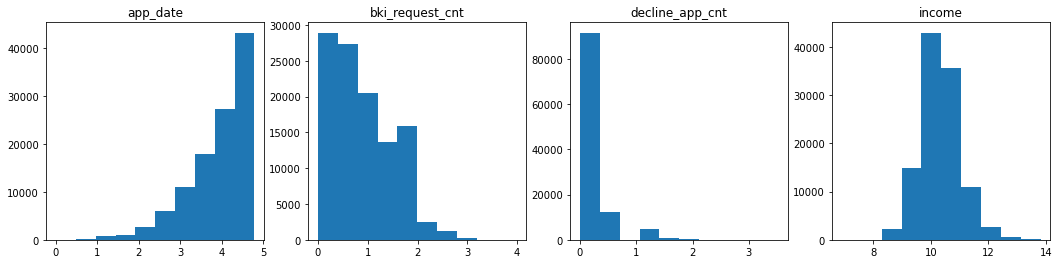

In [45]:
# Normalize distribution
columns = normalize_distribution(df_join)

# Show graphs
cols = 4
rows = math.ceil(len(columns)/cols)
fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))
for i, column in enumerate(columns):
    idx = i%cols if rows == 1 else (i//cols, i%cols) # Plot indices
    axs[idx].hist(df_join.loc[df_join[column].notna(), column])
    axs[idx].set_title(column)

## Dummies generation

In [46]:
def generate_dummies(df, collinear_sens):
    """Dummies generation from categorical features
    
    collinear_sens is ML model collinearity sensitivity. It's either True or False.
    """
    df_out = df
    
    # Generate dummies for categ_multi_cols
    for column in categ_multi_cols:
        df_out = pd.concat([df_out, df[column].str.get_dummies()], axis=1)
    df_out.drop(categ_multi_cols, axis=1, inplace=True)

    # Generate dummies for categ_bin_cols and categ_many_cols
    df_out = pd.get_dummies(df, columns=categ_bin_cols+categ_many_cols, drop_first=collinear_sens)

#     # scikit-learn realization
#     drop = 'first' if collinear_sens else None
#     zzz = pd.DataFrame(OneHotEncoder(drop=drop, sparse=False).fit_transform(df_join[categ_bin_cols + categ_many_cols]))
#     df_out = pd.concat([df_join, zzz], axis=1).drop(categ_bin_cols + categ_many_cols, axis=1)
    
    return df_out

In [47]:
# Generate dummies
df_join = generate_dummies(df_join, collinear_sens=False)

# Model implementation

## Data preparing

In [48]:
# Prepare data
df_join, sample_submission = collect_data()
format_features(df_join)
create_new_features(df_join)
delete_useless_features(df_join)
dirty_handling(df_join)
delete_outliers(df_join, inplace=True)
fill_missing_values(df_join)
df_join = generate_polynomials(df_join, collinear_sens=False)
normalize_distribution(df_join)
df_join = generate_dummies(df_join, collinear_sens=False)

df_temp = df_join.copy()
df_temp

     0 rows have been dropped
   478 NaN have been replaced in column 'education_dup'
   478 NaN have been replaced in column 'education'


,client_id,app_date,age,decline_app_cnt,score_bki,bki_request_cnt,income,default,TRAIN,education_dup,first_time_dup,home_address_dup,region_rating_dup,region_rating_dup_dup,sna_dup,work_address_dup,age_1,client_id_1,income_1,score_bki_1,...,first_time_2,first_time_3,first_time_4,home_address_1,home_address_2,home_address_3,region_rating_1,region_rating_2,region_rating_3,region_rating_4,region_rating_5,region_rating_6,region_rating_7,sna_1,sna_2,sna_3,sna_4,work_address_1,work_address_2,work_address_3
0,25905,3.465736,62,0.000000,-2.008753,0.693147,9.798183,0,1,1.0,1,1,4,4,4,2,0.012308,0.000012,0.000017,0.195578,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1,63161,4.262680,59,0.000000,-1.532276,1.386294,9.852247,0,1,1.0,1,2,4,4,4,3,0.012780,0.000008,0.000017,0.215676,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
2,25887,3.465736,25,1.098612,-1.408142,0.693147,10.308986,0,1,1.0,4,1,7,7,1,2,0.022599,0.000012,0.000014,0.221609,...,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
3,16222,3.135494,53,0.000000,-2.057471,1.098612,9.210440,0,1,1.0,3,2,4,4,1,3,0.013841,0.000014,0.000020,0.193732,...,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
4,101655,4.682131,48,0.000000,-1.244723,0.693147,10.308986,0,1,3.0,4,2,5,5,1,3,0.014870,0.000006,0.000014,0.229936,...,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,4.499810,37,0.693147,-1.744976,1.386294,9.615872,0,0,1.0,1,2,4,4,4,3,0.017778,0.000007,0.000018,0.206216,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
110144,106254,4.744932,64,0.000000,-2.293781,1.386294,12.206078,0,0,3.0,4,1,5,5,1,2,0.012012,0.000006,0.000004,0.185251,...,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
110145,81852,4.488636,31,1.098612,-0.940752,0.693147,11.002117,0,0,3.0,2,1,4,4,4,2,0.019901,0.000007,0.000010,0.247215,...,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
110146,1971,1.945910,27,0.693147,-1.242392,1.098612,10.308986,0,0,2.0,1,2,7,7,1,3,0.021622,0.000018,0.000014,0.230060,...,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1


In [49]:
df_join = df_temp.copy()

## Data splitting & Data scaling

In [50]:
def split_dataframe(data, test_size, stratify=True, normalize=True):
    """Split dataframe to: X, X_train, X_test, y, y_train, y_test"""
    # Split data: Х - features, у - target variable
    y = data.loc[data[TRAIN] == 1, TARGET].values
    X = data.loc[data[TRAIN] == 1].drop([TRAIN, TARGET], axis=1)

    # Split data on train and test parts
    strat = y if stratify else None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=strat, shuffle=True, random_state=RANDOM_SEED)

    if normalize:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    return (X, X_train, X_test, y, y_train, y_test)

In [51]:
# Data splitting
X, X_train, X_test, y, y_train, y_test = split_dataframe(df_join, test_size=0.2)
print('Shapes:', X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)

Shapes: (73799, 192) (59039, 192) (14760, 192) (73799,) (59039,) (14760,)


## Features tuning

In [52]:
def train_test_vs_sample_value(model, data, cv):
    """Calculate train and test scores versus sample value.
    
    It is in order to detect high bias or high variance.
    It also helps to find optimum sample value to fit model for tuning.
    """
    # Input variable
    PART_FACTOR = 5
    
    # Separate train data
    df = data.loc[data[TRAIN] == 1].drop([TRAIN], axis=1)
    y = df[TARGET].values
    
    # Cycle over stratified folds
    score = []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
    for i, (train_index, test_index) in enumerate(skf.split(df.values, y)):
        # Split on train and test
        data_train, data_test = df.iloc[train_index, :], df.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        data_train_0 = data_train.loc[data_train[TARGET] == 0]
        data_train_1 = data_train.loc[data_train[TARGET] == 1]
        X_test = data_test.drop([TARGET], axis=1)
        X_test = StandardScaler().fit_transform(X_test)

        # Define start, stop, step
        START = data_train_1.shape[0] // PART_FACTOR
        STOP = data_train_0.shape[0]
        STEP = START

        # Cycle over train size
        sample_val = []
        score_train = []
        score_test = []
        for train_size in range(START, STOP, STEP):
            # Split and standardize data
            data_train_iter = data_train_1.append(data_train_0.iloc[:train_size, :], ignore_index=True)
            X_train_iter = data_train_iter.drop([TARGET], axis=1)
            X_train_iter = StandardScaler().fit_transform(X_train_iter)
            y_train_iter = data_train_iter[TARGET].values

            # Learn model
            model.fit(X_train_iter, y_train_iter)

            # Test model
            sample_val.append(X_train_iter.shape[0])
            score_train.append(roc_auc_score(y_train_iter, model.predict_proba(X_train_iter)[:,1]))
            score_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
            
            # Print an intermediate result
            print(f'Completed: fold_iteration = {i}; train_size = {X_train_iter.shape[0]}')
        
        # Append fold result
        score.append({'sample_value': sample_val, 'ROC_AUC_train': score_train, 'ROC_AUC_test': score_test})

    # Average result
    length = len(score[0]['sample_value'])
    sample_val = [0]*length
    score_train = [0]*length
    score_test = [0]*length
    for scr in score:
        for i in range(length):
            sample_val[i] += scr['sample_value'][i]
            score_train[i] += scr['ROC_AUC_train'][i]
            score_test[i] += scr['ROC_AUC_test'][i]
    for i in range(length):
        sample_val[i] /= cv
        score_train[i] /= cv
        score_test[i] /= cv
    
    return pd.DataFrame.from_dict({'sample_value': sample_val, 'ROC_AUC_train': score_train, 'ROC_AUC_test': score_test})


def find_usefull_useless_feature(model, data, cv, usefull_cols=None):
    """Find the most usefull or useless feature.
    
    Find the most usefull feature to add if 'usefull_cols' is a list.
    Find the most useless feature to drop if 'usefull_cols' is None.
    """
    # Input variables
    GREATER_SCORE_IS_BETTER = True
    
    # Separate train data
    X = data.loc[data[TRAIN] == 1].drop([TARGET, TRAIN], axis=1)
    y = data.loc[data[TRAIN] == 1, TARGET].values
    
    # Cycle over stratified folds
    f_train_score = defaultdict(int)
    f_test_score = defaultdict(int)
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
    for i, (test_index, train_index) in enumerate(skf.split(X.values, y)): # inverse order of train and test indices
        # Split on train and test
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        
        # Standardize train and test parts
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
        
        # Determine columns list
        if usefull_cols is not None:
            columns = [col for col in X_train.columns if col not in usefull_cols]
        else:
            columns = X_train.columns # [0:110]

        # Cycle over features
        for j, column in enumerate(columns):
            # Define train and test data
            if usefull_cols is not None:
                cols = usefull_cols + [column]
                X_train_temp = X_train[cols]
                X_test_temp = X_test[cols]
            else:
                X_train_temp = X_train.drop(column, axis=1)
                X_test_temp = X_test.drop(column, axis=1)

            # Create and learn model
            model.fit(X_train_temp, y_train)

            # Test model and update dicts
            f_train_score[column] += roc_auc_score(y_train, model.predict_proba(X_train_temp)[:,1])
            f_test_score[column] += roc_auc_score(y_test, model.predict_proba(X_test_temp)[:,1])
            
            # Print an intermediate result
            print(f'fold_iteration {i}, feature_iteration {j} completed')
            if GREATER_SCORE_IS_BETTER:
                feature = max(f_test_score, key=f_test_score.get)
            else:
                feature = min(f_test_score, key=f_test_score.get)
            print(feature, f_test_score[feature])

    # Average result
    for column in f_train_score.keys():
        f_train_score[column] /= cv
        f_test_score[column] /= cv
    
    # Form result DataFrame
    result = pd.DataFrame.from_dict([f_train_score, f_test_score]).transpose().reset_index()
    result.columns = ['feature', 'score_train', 'score_test']
    
    return result.sort_values('score_test', ascending=not GREATER_SCORE_IS_BETTER, ignore_index=True)


def find_several_usefull_useless_features(model, data, features_num, cv, usefull_cols=None):
    """Find several usefull of useless features at a time.
    
    Find the most usefull features to add if 'usefull_cols' is a list.
    Find the most useless features to drop if 'usefull_cols' is None.
    """
    # Find exact features_num
    if usefull_cols is not None:
        features_num = min(features_num, data.shape[1] - len(usefull_cols) - 2) # minus TRAIN and TARGET cols
    else:
        features_num = min(features_num, data.shape[1] - 2) # minus TRAIN and TARGET cols

    # Find features
    useless_cols = []
    features_score = pd.DataFrame(columns=['feature', 'score_train', 'score_test'])
    for i in range(features_num):
        if usefull_cols is not None:
            # Find usefull feature and append it
            df_score = find_usefull_useless_feature(model, data=data, cv=cv, usefull_cols=usefull_cols)
            usefull_cols.append(df_score.iloc[0, 0])
        else:
            # Find useless feature and drop it
            df_score = find_usefull_useless_feature(model, data=data.drop(useless_cols, axis=1), cv=cv)
            useless_cols.append(df_score.iloc[0, 0])

        # Print an intermediate result
        features_score = features_score.append(df_score.iloc[0], ignore_index=True)
        features_score.to_csv('train_test_score_vs_feature_number_new.csv', index=False)
        print('Feature number =', i)
        print(features_score)
        
    return features_score

    sample_value  ROC_AUC_train  ROC_AUC_test
33       65786.0       0.735886      0.734862


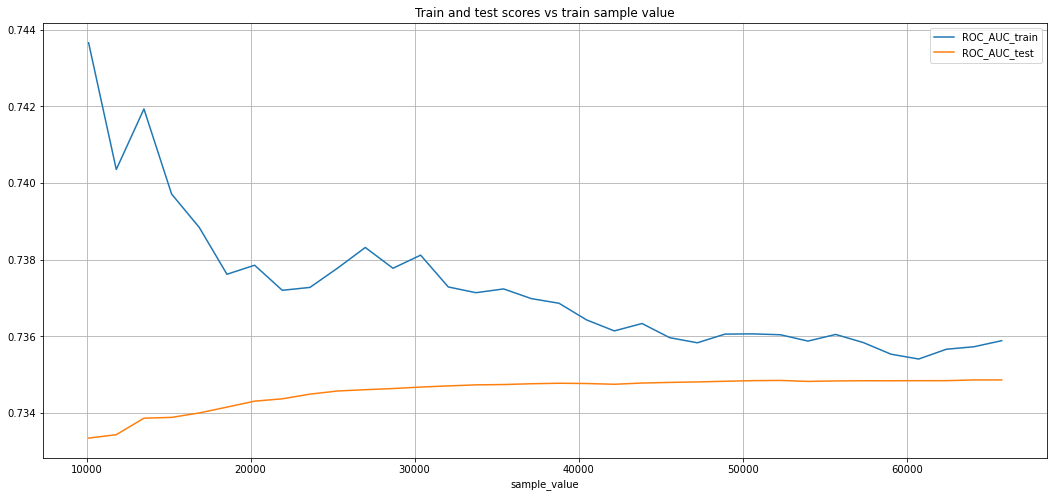

In [53]:
# usefull_cols = [
#        'score_bki region_rating_dup_dup', 'home_address_2', 'sna_dup',
#        'bki_request_cnt_1 decline_app_cnt_1', 'education_dup',
#        'app_date score_bki', 'sex_F', 'first_time_dup', 'car_type_N',
#        'score_bki decline_app_cnt_1', 'region_rating_7',
#        'work_address_dup', 'region_rating_dup_dup bki_request_cnt_1',
#        'first_time_1', 'good_work_0', 'age score_bki',
#        'region_rating_dup_dup age_1', 'client_id_1 score_bki_1',
#        'foreign_passport_N', 'sna_2', 'age region_rating_dup_dup_1',
#        'age_1 decline_app_cnt_1', 'decline_app_cnt income', 'app_date',
#        'decline_app_cnt',
# ]

# Compute train and test scores versus sample value to define whether the model has high bias or high variance
# and find optimum train-test sample proportion to tune features
# model = LogisticRegression(class_weight={0:1,1:5}, C=40, max_iter=1000, n_jobs=-1, verbose=1)
# %time score = train_test_vs_sample_value(model, df_join[usefull_cols + [TARGET, TRAIN]], cv=10)

# Update sample value score dataframe
score = pd.read_csv(PATH_KERNEL+'train_test_score_vs_sample_value.csv')
score.to_csv('train_test_score_vs_sample_value.csv', index=False)

# Plot train and test scores versus sample value
score.plot(x='sample_value', figsize=(18, 8), grid=True, title='Train and test scores vs train sample value')
print(score.nlargest(1, 'ROC_AUC_test'))

The sample value of 25000 for train set is a good choice to find usefull features

                 feature  score_train  score_test  features number
55  app_date score_bki_1     0.740299    0.736571               56


array(['score_bki region_rating_dup_dup', 'home_address_2', 'sna_dup',
       'bki_request_cnt_1 decline_app_cnt_1', 'education_dup',
       'app_date score_bki', 'sex_F', 'first_time_dup', 'car_type_Y',
       'score_bki decline_app_cnt_1', 'region_rating_7', 'work_address_1',
       'region_rating_dup_dup bki_request_cnt_1', 'first_time_1',
       'good_work_1', 'client_id_1', 'age_1 income_1', 'region_rating_5',
       'region_rating_dup_dup_1 score_bki_1', 'sna_3',
       'score_bki income_1', 'region_rating_dup_dup age_1', 'client_id^2',
       'client_id', 'app_date client_id', 'foreign_passport_N', 'sna_1',
       'work_address_3', 'decline_app_cnt income_1',
       'decline_app_cnt score_bki', 'income region_rating_dup_dup_1',
       'income region_rating_dup_dup', 'app_date region_rating_dup_dup_1',
       'work_address_2', 'work_address_dup', 'car_type_N', 'sna_4',
       'good_work_0', 'sex_M', 'education_PGR', 'foreign_passport_Y',
       'education_NaN_0', 'sna_2', 'educat

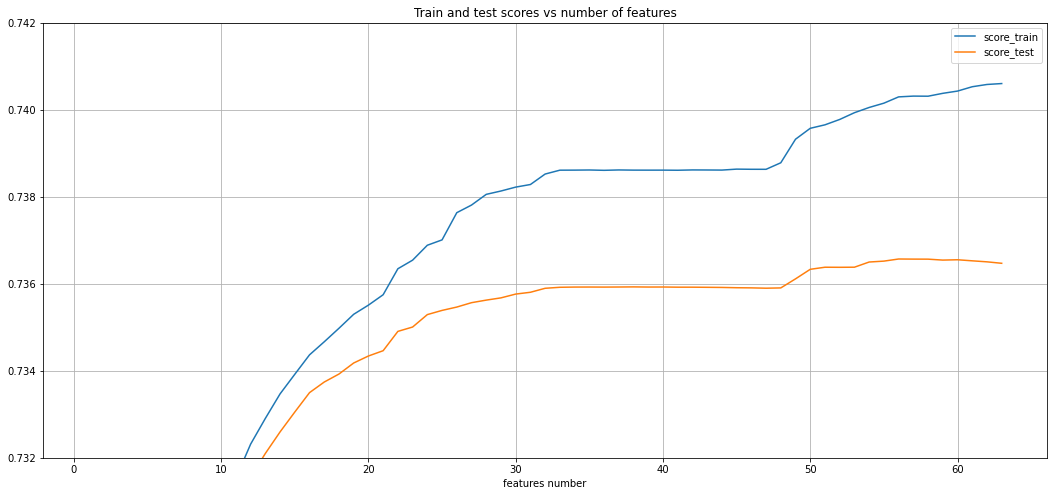

In [54]:
# Already found usefull features
usefull_cols = [
# baseline
#     'client_id',
#     'age','app_date','bki_request_cnt',
#     'decline_app_cnt','education_dup','first_time_dup',
#     'home_address_dup','income','region_rating_dup',
#     'score_bki','sna_dup','work_address_dup',
    
# iteration 1
#        'score_bki region_rating_dup_dup', 'home_address_2', 'sna_dup',
#        'bki_request_cnt_1 decline_app_cnt_1', 'education_dup',
#        'app_date score_bki', 'sex_F', 'first_time_dup', 'car_type_N',
#        'score_bki decline_app_cnt_1', 'region_rating_7',
#        'work_address_dup', 'region_rating_dup_dup bki_request_cnt_1',
#        'first_time_1', 'good_work_0', 'age score_bki',
#        'region_rating_dup_dup age_1', 'client_id_1 score_bki_1',
#        'foreign_passport_N', 'sna_2', 'age region_rating_dup_dup_1',
#        'age_1 decline_app_cnt_1', 'decline_app_cnt income', 'app_date',
#        'decline_app_cnt', 'sna_3', 'region_rating_5', 'bki_request_cnt^2',
#        'sna_1', 'sex_M', 'foreign_passport_Y', 'car_type_Y',
#        'good_work_1', 'sna_4', 'client_id score_bki',
#        'client_id bki_request_cnt_1', 'region_rating_dup_dup app_date_1',
#        'client_id income_1', 'region_rating_dup_dup client_id_1',
#        'app_date bki_request_cnt_1', 'region_rating_dup_dup client_id_1',
#        'app_date bki_request_cnt_1', 'income^2', 'app_date income_1',
#        'region_rating_6', 'client_id decline_app_cnt_1',
#        'app_date decline_app_cnt_1', 'app_date_1^2',
#        'app_date_1 client_id_1', 'client_id_1^2',
#        'app_date_1 score_bki_1', 'bki_request_cnt_1 client_id_1',
#        'app_date_1 bki_request_cnt_1', 'age_1 bki_request_cnt_1',
#        'bki_request_cnt region_rating_dup_dup', 'score_bki age_1',
#        'bki_request_cnt score_bki', 'bki_request_cnt_1 income_1',
#        'score_bki income_1', 'region_rating_dup_dup income_1', 'income',
#        'income_1 score_bki_1', 'income bki_request_cnt_1',
#        'age region_rating_dup_dup', 'region_rating_dup_dup_1 client_id_1',
#        'client_id^2', 'income_1^2', 'client_id_1',
    
# iteration 2
       'score_bki region_rating_dup_dup', 'home_address_2', 'sna_dup',
       'bki_request_cnt_1 decline_app_cnt_1', 'education_dup',
       'app_date score_bki', 'sex_F', 'first_time_dup', 'car_type_Y',
       'score_bki decline_app_cnt_1', 'region_rating_7', 'work_address_1',
       'region_rating_dup_dup bki_request_cnt_1', 'first_time_1',
       'good_work_1', 'client_id_1', 'age_1 income_1', 'region_rating_5',
       'region_rating_dup_dup_1 score_bki_1', 'sna_3',
       'score_bki income_1', 'region_rating_dup_dup age_1', 'client_id^2',
       'client_id', 'app_date client_id', 'foreign_passport_N', 'sna_1',
       'work_address_3', 'decline_app_cnt income_1',
       'decline_app_cnt score_bki', 'income region_rating_dup_dup_1',
       'income region_rating_dup_dup', 'app_date region_rating_dup_dup_1',
       'work_address_2', 'work_address_dup', 'car_type_N', 'sna_4',
       'good_work_0', 'sex_M', 'education_PGR', 'foreign_passport_Y',
       'education_NaN_0', 'sna_2', 'education_NaN_1', 'region_rating_6',
       'app_date^2', 'region_rating_dup_dup decline_app_cnt_1', 'age_1^2',
       'age_1', 'age^2', 'age', 'region_rating_dup_dup income_1',
       'income', 'income_1 score_bki_1', 'income^2',
       'app_date score_bki_1', 'car_N', 'car_Y',
]

# Compute next usefull features
# cv = round(df_join.shape[0] / 25000)
# cv = cv if cv >= 2 else 2
# model = LogisticRegression(class_weight={0:1,1:5}, C=40, max_iter=1000, n_jobs=-1, verbose=1)
# %time find_several_usefull_useless_features(model, df_join, features_num=50, cv=cv, usefull_cols=usefull_cols)

# Update features score dataframe
# First time
# features_score = pd.read_csv(PATH_WORKING+'train_test_score_vs_feature_number_new.csv')
# features_score.to_csv('train_test_score_vs_feature_number.csv', index=False)
# Next times
# features_score = pd.read_csv(PATH_KERNEL+'train_test_score_vs_feature_number.csv')
# features_score_new = pd.read_csv(PATH_WORKING+'train_test_score_vs_feature_number_new.csv')
# features_score = features_score.append(features_score_new, ignore_index=True)
# features_score.to_csv('train_test_score_vs_feature_number.csv', index=False)
# Done
features_score = pd.read_csv(PATH_KERNEL+'train_test_score_vs_feature_number.csv')
features_score.to_csv('train_test_score_vs_feature_number.csv', index=False)

# Plot train and test scores versus number of features
features_score['features number'] = features_score.index + 1
features_score.plot(x='features number', figsize=(18, 8), grid=True,
    title='Train and test scores vs number of features', ylim=(0.732, 0.742));
print(features_score.nlargest(1, 'score_test'))
features_score['feature'].values

## Hyperparameters tuning

In [ ]:
# Show available metrics to optimize hyperparameters
# sorted(SCORERS.keys())

In [ ]:
def tune_class_balance(X, y, weights, C=1, cv=5):
    """Find optimum class weights"""
    # Define cross validation
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
    
    # Define model
    model = LogisticRegression(C=C, max_iter=1000, verbose=1, n_jobs=-1)
    
    # Define and fit grid search
    model = GridSearchCV(estimator=model, param_grid=dict(class_weight=weights), scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
    model.fit(X, y)
    
    # Print the best configuration
    print("Best score: %f using %s" % (model.best_score_, model.best_params_))


def tune_regularization(X, y, Cs, weight={0:1,1:1}, cv=5):
    """Find optimum regularization parameter C"""
    # Define cross validation
    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
    
    # Define and fit model
    model = LogisticRegressionCV(Cs=Cs, cv=cv, class_weight=weight, scoring='roc_auc', max_iter=1000, n_jobs=-1, verbose=1)
    model.fit(X, y)

    print('C_ =', model.C_)
    print('Cs_ =', model.Cs_)
    print('scores_ =', model.scores_)

In [ ]:
# Show balanced weights
compute_class_weight('balanced', classes=np.unique(y), y=y)

# Find the best class weights
weights = [{0:1,1:2}, {0:1,1:3}, {0:1,1:4}, {0:1,1:5}, {0:1,1:6}]
weights = [{0:1,1:4.9}, {0:1,1:5.1}, {0:1,1:5.3}, {0:1,1:5.5}, {0:1,1:5.7}]
# tune_class_balance(X[usefull_cols], y, weights=weights, C=1, cv=2)

In [ ]:
# Find the best regularization parameter C
Cs = np.logspace(-0.2, 0.1, 10)
Cs = [0.1, 1, 10]
Cs = [45, 46, 47, 48, 49]
# tune_regularization(X[usefull_cols], y, weight={0:1,1:5.3}, Cs=Cs, cv=5)

## Model testing

In [ ]:
# Define cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)

# Define model
model = LogisticRegression(class_weight={0:1,1:5}, C=40, max_iter=1000, n_jobs=-1, verbose=1)

# Evaluate model
score = cross_val_score(model, X[usefull_cols], y, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
print('Shapes:', X[usefull_cols].shape, y.shape)
print('Mean ROC AUC score =', statistics.mean(score))


# Fit model on test set
model.fit(X_train[usefull_cols], y_train)
# View important model characteristics
print('classes_ =', model.classes_)
print('coef_ =', model.coef_)
print('intercept_ =', model.intercept_)
# Test model
score = roc_auc_score(y_test, model.predict_proba(X_test[usefull_cols])[:,1])
# Plot ROC AUC curve
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test[usefull_cols])[:,1])
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % score)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Submission
**Learn model on 100% of train data**

In [ ]:
# Create and learn model
model = LogisticRegression(class_weight={0:1,1:5}, C=40, max_iter=1000, n_jobs=-1, verbose=1)
model.fit(X[usefull_cols], y)

# Splitting and scaling data to predict
X_predict = df_join.loc[df_join[TRAIN] == 0, usefull_cols]
X_predict = StandardScaler().fit_transform(X_predict)
model.predict_proba(X_predict)[:,1]

# Predict target variable
predict_submission = model.predict_proba(X_predict)[:,1]

# Postprocess
pass

**Write result to submission file**

In [ ]:
sample_submission = pd.DataFrame()
sample_submission[IDENT] = df_join.loc[df_join[TRAIN] == 0, IDENT].values
sample_submission[TARGET] = predict_submission
sample_submission.reset_index(drop=True, inplace=True)
sample_submission.to_csv('submission.csv', index=False)
sample_submission

# What's next?
Или, что делать, чтобы улучшить результат:

- Try KNeighborsClassifier
- Feature Engineering (tune every feature, -1 degree features, polynomial features)
- Tune hyperparameters
- Working with unbalanced sample (over & under sampling; class weights)

In [ ]:
def baseline():
    def split_dataframe_(df, test_size, normalize):
        y = df[TARGET].values
        X = df.drop([TARGET], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED)

        if normalize:
            scaler = StandardScaler()
            X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
            X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
            X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
        return (X, X_train, X_test, y, y_train, y_test)
    
    df_join_ = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')

    df_join_['education_NaN'] = df_join_['education'].isna().astype('uint8')
    df_join_['education'].fillna('SCH', inplace=True)
    df_join_.drop('client_id', axis=1, inplace=True)

    categ_bin_cols_ = [
        'sex',
        'car',
        'car_type',
        'good_work',
        'foreign_passport',
        'education_NaN',
    ]
    categ_many_cols_ = [
        'home_address',
        'work_address',
        'education',
    ]
    quantity_cols_ = [
        'age',
        'income',
        'client_id',
        'decline_app_cnt',
        'bki_request_cnt',
    ]
    
    df_join_['age'] = df_join_['age'].apply(lambda x: np.log1p(x))
    df_join_['income'] = df_join_['income'].apply(lambda x: np.log1p(x))
    df_join_['decline_app_cnt'] = df_join_['decline_app_cnt'].apply(lambda x: np.log1p(x))
    df_join_['bki_request_cnt'] = df_join_['bki_request_cnt'].apply(lambda x: np.log1p(x))
    
    df_join_ = pd.get_dummies(df_join_, columns=categ_bin_cols_+categ_many_cols_, drop_first=False)
    
    # Split data
    X, X_train, X_test, y, y_train, y_test = split_dataframe_(df_join_, test_size=0.2, normalize=True)
    # Check data dimensions
    print('Shapes:', X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)
    # Create and learn model
    model = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)
    # View important model characteristics
    print('classes_ =', model.classes_)
    print('coef_ =', model.coef_)
    print('intercept_ =', model.intercept_)
    # Test model
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print('ROC AUC =', score)
    
# baseline()